In [20]:
import os
os.chdir('/home/kt/calc/latticeG')

In [21]:
import torch
import scipy.io as sio
from hamiltonians.Central import SSH2DChainMethod
from hamiltonians.Lead import SpinlessLead
from calculations.calculation_cf_autograd import calculation_cf_autograd
from greens_functions.transport_calculation import calculate_transport_properties
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

# Define device for computations
funcDevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {funcDevice}")

# --- 1. Define SSH Model Parameters ---
Nx_cell, Ny_cell = 10, 10  # Number of unit cells in x and y directions
Nx, Ny = Nx_cell * 2, Ny_cell * 2  # Total number of sites (2 sites per unit cell in each direction)
orb_size = 1  # Orbital size for 2D SSH model

# Define SSH parameters (using complex tensors for consistency)
gamma_x = torch.tensor(0.5, dtype=torch.complex64, device=funcDevice)  # Intra-cell hopping along x
gamma_y = torch.tensor(0.5, dtype=torch.complex64, device=funcDevice)  # Intra-cell hopping along y
lambda_x = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Inter-cell hopping along x
lambda_y = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Inter-cell hopping along y

# Print model parameters for verification
print(f"System size: {Nx_cell}×{Ny_cell} unit cells ({Nx}×{Ny} sites)")
print(f"Model parameters: γx={gamma_x}, γy={gamma_y}, λx={lambda_x}, λy={lambda_y}")

Using device: cpu
System size: 10×10 unit cells (20×20 sites)
Model parameters: γx=(0.5+0j), γy=(0.5+0j), λx=(1+0j), λy=(1+0j)


In [22]:
# --- 2. Create SSH Hamiltonian using Chain Method ---
print("Constructing 2D SSH Hamiltonian...")
ssh2d_model = SSH2DChainMethod(Nx_cell, Ny_cell, gamma_x, gamma_y, lambda_x, lambda_y)

# Convert to BdG form for particle-hole calculations (similar to the vortex model)
# This creates a block form with the Hamiltonian and its conjugate in the diagonal blocks
H_2d_BdG = torch.kron(ssh2d_model.H_full, torch.tensor([[1, 0], [0, 0]], dtype=torch.complex64, device=funcDevice)) + \
           torch.kron(-ssh2d_model.H_full.conj(), torch.tensor([[0, 0], [0, 1]], dtype=torch.complex64, device=funcDevice))

print(f"Hamiltonian shape: {H_2d_BdG.shape}")

# Verify Hamiltonian is Hermitian (important for physical properties)
hermitian_check = torch.allclose(H_2d_BdG, H_2d_BdG.conj().transpose(-1, -2), atol=1e-6)
print(f"Hamiltonian is Hermitian: {hermitian_check}")

Constructing 2D SSH Hamiltonian...
Hamiltonian shape: torch.Size([800, 800])
Hamiltonian is Hermitian: True


In [23]:
# --- 3. Define Lead Parameters ---
mu_values = torch.tensor([-10.0, 10.0], dtype=torch.float32, device=funcDevice)  # Chemical potentials
t_lead_central = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Coupling strength
t_lead = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Hopping within lead
temperature = torch.tensor(0.0, dtype=torch.float32, device=funcDevice)  # Temperature

# --- 4. Create Lead Objects ---
print("Creating leads...")
# We connect the leads to opposite corners of the system
leads_info = []

# Lead 1 at bottom-left corner (0,0)
leads_info.append(
    SpinlessLead(
        mu=mu_values[0],
        t_lead_central=t_lead_central,
        temperature=temperature,
        connection_coordinates=[(0, 0)],  # Connect to bottom-left corner
        central_Nx=Nx,
        central_Ny=Ny,
        t_lead=t_lead
    )
)

# Lead 2 at top-right corner (0, Ny-1)
leads_info.append(
    SpinlessLead(
        mu=mu_values[1],
        t_lead_central=t_lead_central,
        temperature=temperature,
        connection_coordinates=[(0, Ny-1)],  # Connect to top-right corner
        central_Nx=Nx,
        central_Ny=Ny,
        t_lead=t_lead
    )
)

# Print lead connection information
for i, lead in enumerate(leads_info):
    print(f"Lead {i} connection coordinates: {lead.connection_coordinates}, μ={mu_values[i]}")

Creating leads...
Lead 0 connection coordinates: [(0, 0)], μ=-10.0
Lead 1 connection coordinates: [(0, 19)], μ=10.0


In [24]:
# --- 5. Define Energy Grid for Calculations ---
# Define energy range and resolution
E_min, E_max = -2.0, 2.0  # Energy range around the expected gap
num_points = 400  # Number of energy points for calculation
E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)
eta = torch.tensor(1e-2, dtype=torch.float32, device=funcDevice)  # Broadening parameter

# --- 6. Calculate Transport Properties ---
# Split calculation into chunks to manage memory
chunk_size = 4  # Adjust based on available memory
num_chunks = (num_points + chunk_size - 1) // chunk_size

# Initialize lists to store results
all_ldos = []
all_rho_electron = []
all_rho_hole = []
all_transmission = []
all_andreev = []
all_current = []
all_noise = []
all_current_density = {direction: [] for direction in ['right', 'up', 'right2', 'up2']}

print("Calculating transport properties in chunks...")
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, num_points)
    E_chunk = E[start_idx:end_idx]
    
    print(f"Processing chunk {i+1}/{num_chunks} (E = {E_chunk[0]:.3f} to {E_chunk[-1]:.3f})")
    
    # Calculate transport properties for this chunk
    chunk_results = calculate_transport_properties(
        E_batch=E_chunk,
        H_total=H_2d_BdG,
        leads_info=leads_info,
        temperature=temperature,
        eta=eta,
        method='direct',
        Nx=Nx,
        Ny=Ny,
        orb_num=1  # ssh no spin
    )
    
    all_ldos.append(chunk_results['rho_e_jj'])
    all_rho_electron.append(chunk_results['rho_electron'])
    all_rho_hole.append(chunk_results['rho_hole'])
    all_transmission.append(chunk_results['transmission'])
    all_andreev.append(chunk_results['andreev'])
    all_current.append(chunk_results['current'])
    all_noise.append(chunk_results['noise'])
    
    # Collect current density for each direction
    for direction in ['right', 'up', 'right2', 'up2']:
        all_current_density[direction].append(chunk_results['current_density'][direction])

# Combine results from all chunks
ldos = torch.cat(all_ldos, dim=0)
transmission = torch.cat(all_transmission, dim=0)
andreev = torch.cat(all_andreev, dim=0)
current = torch.cat(all_current, dim=0)

# Combine current density results
for direction in ['right', 'up', 'right2', 'up2']:
    all_current_density[direction] = torch.cat(all_current_density[direction], dim=0).detach().cpu().numpy()

print("Transport calculations complete.")

Calculating transport properties in chunks...
Processing chunk 1/100 (E = -2.000 to -1.970)


Processing chunk 2/100 (E = -1.960 to -1.930)
Processing chunk 3/100 (E = -1.920 to -1.890)
Processing chunk 4/100 (E = -1.880 to -1.850)
Processing chunk 5/100 (E = -1.840 to -1.810)
Processing chunk 6/100 (E = -1.799 to -1.769)
Processing chunk 7/100 (E = -1.759 to -1.729)
Processing chunk 8/100 (E = -1.719 to -1.689)
Processing chunk 9/100 (E = -1.679 to -1.649)
Processing chunk 10/100 (E = -1.639 to -1.609)
Processing chunk 11/100 (E = -1.599 to -1.569)
Processing chunk 12/100 (E = -1.559 to -1.529)
Processing chunk 13/100 (E = -1.519 to -1.489)
Processing chunk 14/100 (E = -1.479 to -1.449)
Processing chunk 15/100 (E = -1.439 to -1.409)
Processing chunk 16/100 (E = -1.398 to -1.368)
Processing chunk 17/100 (E = -1.358 to -1.328)
Processing chunk 18/100 (E = -1.318 to -1.288)
Processing chunk 19/100 (E = -1.278 to -1.248)
Processing chunk 20/100 (E = -1.238 to -1.208)
Processing chunk 21/100 (E = -1.198 to -1.168)
Processing chunk 22/100 (E = -1.158 to -1.128)
Processing chunk 23/1

In [25]:
# --- 7. Save Results ---
# Create a timestamped directory to save results
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
this_run_dir = f'ssh2d_Nx{Nx_cell}_Ny{Ny_cell}_gx{gamma_x.item():.1f}_gy{gamma_y.item():.1f}_lx{lambda_x.item():.1f}_ly{lambda_y.item():.1f}_{timestamp}'
os.makedirs(this_run_dir, exist_ok=True)

print(f"Saving results to directory: {this_run_dir}")

# Save data to matlab format for analysis
sio.savemat(f'{this_run_dir}/ssh2d_transport_data.mat', {
    'ldos': ldos.detach().cpu().numpy(),
    'energy': E.detach().cpu().numpy(),
    'transmission': transmission.detach().cpu().numpy(),
    'andreev': andreev.detach().cpu().numpy(),
    'current': current.detach().cpu().numpy(),
    'gamma_x': gamma_x.item(),
    'gamma_y': gamma_y.item(),
    'lambda_x': lambda_x.item(),
    'lambda_y': lambda_y.item(),
    'all_current_density': all_current_density
})

print(f"Results saved to {this_run_dir}/ssh2d_transport_data.mat")

Saving results to directory: ssh2d_Nx10_Ny10_gx0.5+0.0j_gy0.5+0.0j_lx1.0+0.0j_ly1.0+0.0j_20250418_213133
Results saved to ssh2d_Nx10_Ny10_gx0.5+0.0j_gy0.5+0.0j_lx1.0+0.0j_ly1.0+0.0j_20250418_213133/ssh2d_transport_data.mat


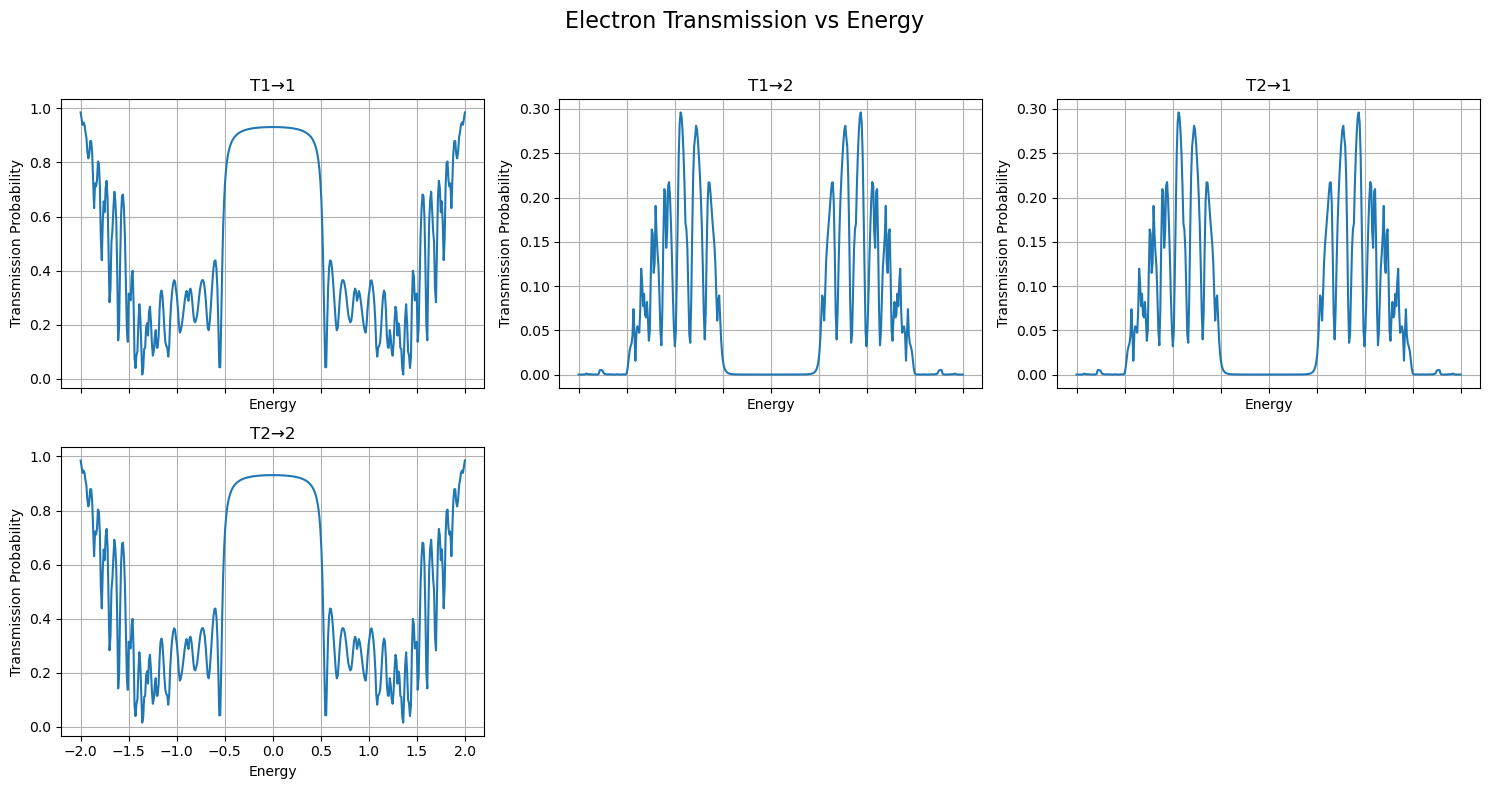

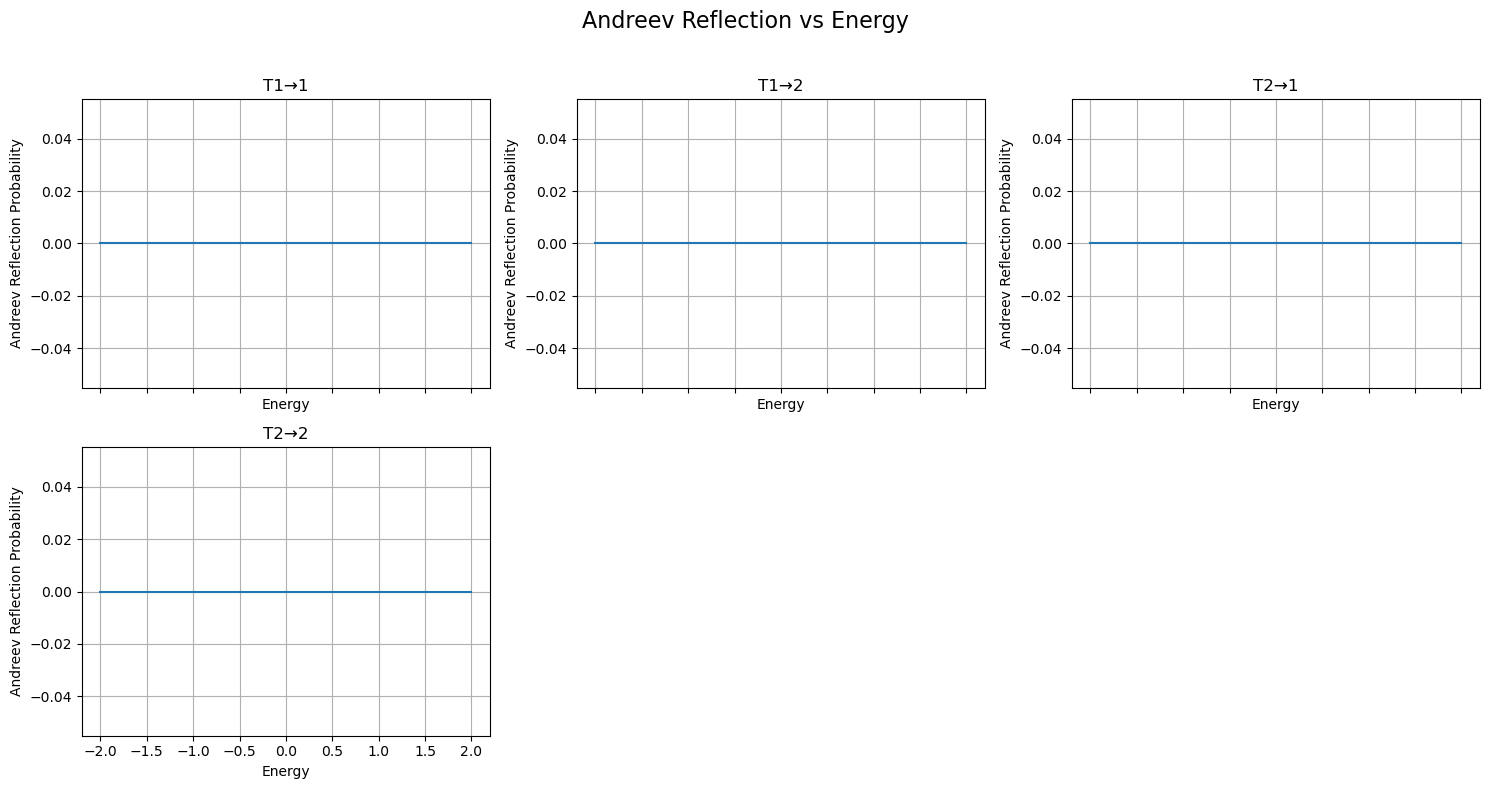

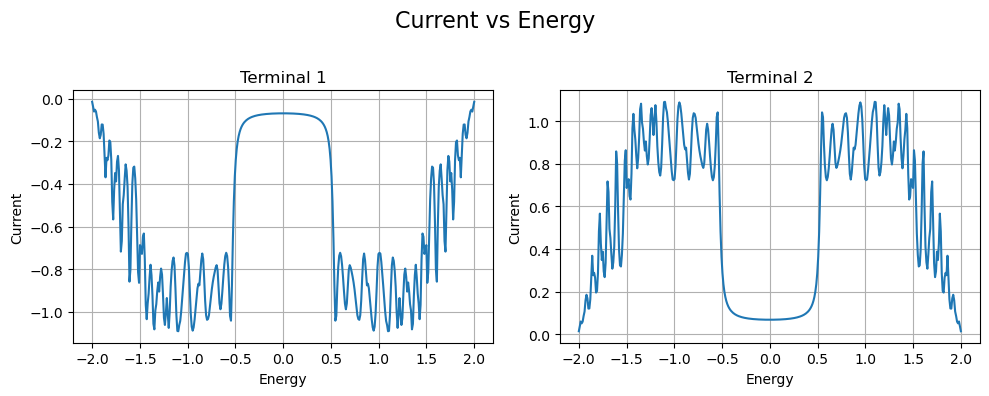

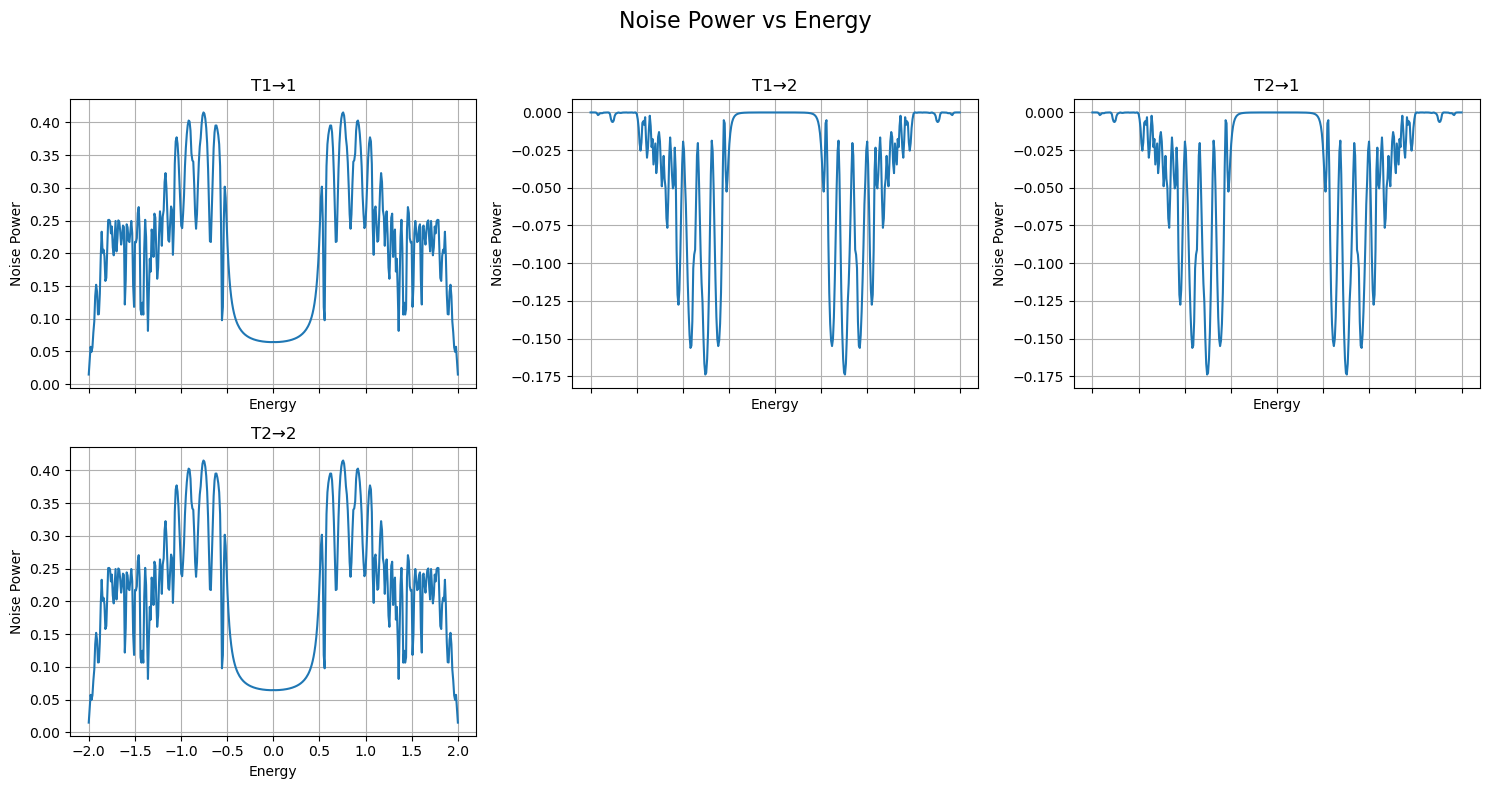

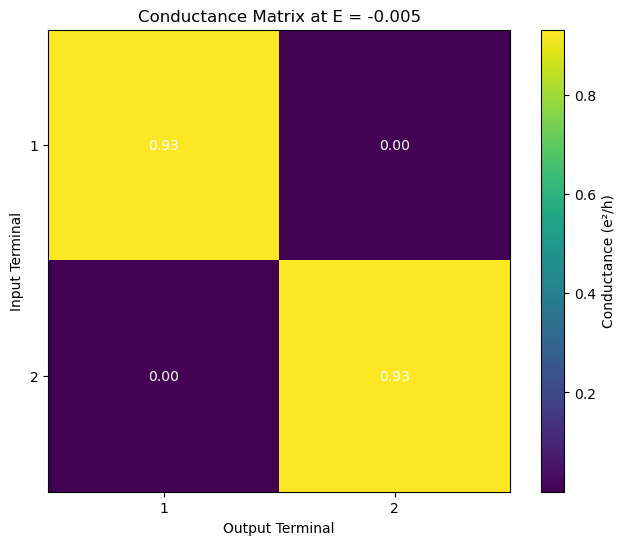

In [26]:
# After calculating results
from dataplot.transport_plot import plot_all_transport_quantities, plot_conductance_matrix

# Combine all chunks
all_transmission = torch.cat(all_transmission, dim=0)
all_andreev = torch.cat(all_andreev, dim=0)
all_current = torch.cat(all_current, dim=0)
all_noise = torch.cat(all_noise, dim=0)

# Create transport data dictionary
transport_data = {
    'transmission': all_transmission,
    'andreev': all_andreev,
    'current': all_current,
    'noise': all_noise
}

# Plot all transport quantities
plot_all_transport_quantities(
    E_values=E,
    transport_data=transport_data,
    save_dir=f'{this_run_dir}/transport_plots'
)

# Plot conductance matrix at zero energy
plot_conductance_matrix(
    E_values=E,
    transport_data=transport_data,
    energy_point=0.0,
    save_path=f'{this_run_dir}/conductance_matrix_E0.png'
)